 # Phase 1 - Ingestion and Cleaning

 This notebook carries out the following steps
   1. Ingest data downloaded from the LendingClub website
   2. Choose columns to examine and prepare the data set
   3. Visualizes single variable summaries
   4. Removes outliers
   5. Output a dataset ready for later analysis

 Things for you to add
 - Choose 3 to 5 variables and add them to the list of variables below
 - Try visualizing the new variables and other pairs of variables

 Prepare your presentation. Your presentation should contain at most 6 slides.
 1. Begin by giving an overview of the project. What is the problem you wish to solve, what are the objectives? How will you evaluate the performance of the portfolio you provide? How will you measure success? What are the business KPIs?
 2. What variables did you select for further inspection? Why do you think they will be useful? You may support any argument with a visualization.
 3. List any insight you gained by looking at the data visualization or any other data analysis that you perform.
 4. List 3-5 hypothesis about which variables will be important for analysis, and how they will affect the outcome.
 5. State your conclusions. What is the main idea you wish to convey with the presentation? Do you think the data available will be useful to solve the problem?

In [1]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn


In [2]:
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False


 ## Parameters

In [3]:
#You can download the archived data for 2014 from the WayBack machine here: 
# https://web.archive.org/web/20160703081246/https://resources.lendingclub.com/LoanStats3c.csv.zip
# For the 2012-13 data, use https://web.archive.org/web/20160703081246/https://resources.lendingclub.com/LoanStats3b.csv.zip 
# Download both zip files and unzip them.
# Put both these unzipped files in the appropriate folder ("../data" below) before proceeding below.
# The data dictionary is here: https://web.archive.org/web/20200606105339/https://resources.lendingclub.com/LCDataDictionary.xlsx}
dir_data= "../data"


 ## Step 1 - Ingestion
 Ingest the data files from both sets, perform consistency checks, and prepare one single file for each set

In [4]:
from typing import Dict, final
def ingest_files(directory: str) -> Dict:
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    Lending Club, and *only* those files. Thus, we assume the files are zipped
    (pd.read_csv can read zipped files) and we assume the first line
    in each file needs to be skipped. 
    
    Note that this function will read and ingest more than one file and is
    convenient if you want to ingest data for more than one year at a time.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory = directory + "/"
    
    all_files = os.listdir(directory)
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(directory + i, dtype = str, skiprows = 1)
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = (output[i].id.apply( lambda x : is_integer(x) == False ))
        if invalid_rows.sum() > 0:
            print("        Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = output[i][invalid_rows == False]
    
    return output


In [7]:
# Ingest the set of files we downloaded 
files_data = ingest_files(dir_data)


Directory ../data/ has 2 files:
    Reading file LoanStats3b.csv
        Found 2 invalid rows which were removed
    Reading file LoanStats3c.csv
        Found 2 invalid rows which were removed


In [8]:
files_data.keys()

dict_keys(['LoanStats3b.csv', 'LoanStats3c.csv'])

In [11]:
data_now = pd.concat(files_data.values()).reset_index(drop = True)
columns = list(data_now.columns)
columns

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_

 ## Step 2 - Choose Columns and Prepare Dataset

In [12]:
# Identify the columns we'll be keeping from the dataset
cols_to_pick = ['id','loan_amnt','funded_amnt','term','int_rate',
                 'installment','grade','emp_length', 'home_ownership',
                 'annual_inc','verification_status','issue_d',
                 'loan_status','purpose','dti', 'delinq_2yrs',
                 'earliest_cr_line','open_acc','pub_rec',
                 'revol_bal','revol_util', 'total_pymnt',
                 'last_pymnt_d', 'recoveries']

# Identify the type of each of these column
float_cols = ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc',
                     'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'pub_rec',
                                'total_pymnt', 'recoveries']
cat_cols = ['term', 'grade', 'emp_length', 'home_ownership',
                    'verification_status', 'loan_status', 'purpose']
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])


In [13]:
# Keep only the columns of interest
final_data = data_now[cols_to_pick].copy()


In [14]:
print("Starting with " + str(len(final_data)) + " rows")


Starting with 423752 rows


 # To do (A)

 Choose 3 to 5 variables and add them to the list of variables below

 You should consult the data description (excel) file you downloaded to understand the definition of various available columns

 TIP: If you added new variables, be sure to clean them as we just did for the default variables.

 You will have to add them to the group of the right type of variables (e.g. percentage, date, categorical)


 ### Typecast the columns

In [15]:
for i in float_cols:
    final_data[i] = final_data[i].astype(float)
    
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.rstrip()[:-1])
for i in perc_cols:
    final_data[i] = final_data[i].apply( clean_perc )
    
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()
for i in date_cols:
    final_data[i] = final_data[i].apply( clean_date )
    
for i in cat_cols:
    final_data.loc[final_data[i].isnull(), i] = None


In [16]:
final_data.head()


,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,dti,delinq_2yrs,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_pymnt,last_pymnt_d,recoveries
0,10129403,7550.0,7550.0,36 months,16.24,266.34,C,3 years,RENT,28000.0,...,8.40,0.0,2010-10-01,4.0,0.0,5759.0,72.0,7739.080000,2016-06-01,0.0
1,10149342,27050.0,27050.0,36 months,10.99,885.46,B,10+ years,OWN,55000.0,...,22.87,0.0,1986-10-01,14.0,0.0,36638.0,61.2,25678.340000,2016-06-01,0.0
2,10159584,9750.0,9750.0,36 months,13.98,333.14,C,1 year,RENT,26000.0,...,25.12,0.0,2007-01-01,12.0,0.0,7967.0,52.8,9660.530000,2016-06-01,0.0
3,10159498,12000.0,12000.0,36 months,6.62,368.45,A,10+ years,MORTGAGE,105000.0,...,14.05,0.0,1994-03-01,12.0,0.0,13168.0,21.6,10685.050000,2016-06-01,0.0
4,10129506,20800.0,20800.0,36 months,13.53,706.16,B,10+ years,RENT,81500.0,...,16.73,0.0,1998-06-01,29.0,0.0,23473.0,54.5,23926.640008,2015-05-01,0.0


 ## Step 3- Visualize the variables

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
def visualize_columns():
    '''
    This function visualizes all columns
      - Box-and-whisker plots for continuous variables
      - Lists of distinct values for categorical columns
      - A timeline density for dates
    '''
    
    # Float columns
    for i in float_cols + perc_cols:
        # seaborn.boxplot(final_data[i])
        final_data.boxplot(i)

        # Print the three highest values
        highest_vals = sorted(final_data[i], reverse=True)[:3]
        smallest_val = min(final_data[i])
        print("Top 3 Max: ", highest_vals, "\nMin: ", smallest_val)
        # plt.text(smallest_val, -0.3, highest_vals[0])
        # plt.text(smallest_val, -0.2, highest_vals[1])
        # plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()
        
    # Categorical columns 
    for i in cat_cols:
        print(i)
        print(str(len(set(final_data[i]))) + " distinct values")
        print(final_data[i].value_counts())
        print("")
        print("")
    
    # Date columns
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()


<Figure size 400x400 with 0 Axes>

Top 3 Max:  [35000.0, 35000.0, 35000.0] 
Min:  1000.0


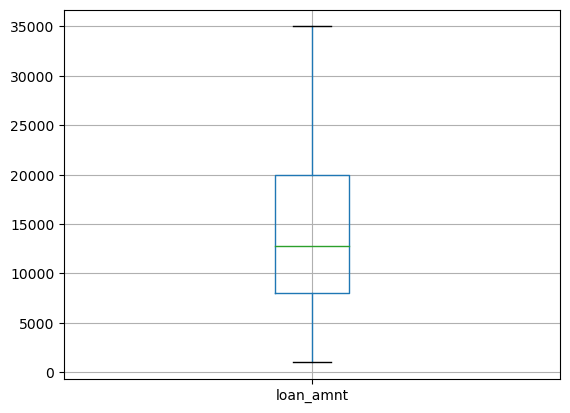

Top 3 Max:  [35000.0, 35000.0, 35000.0] 
Min:  1000.0


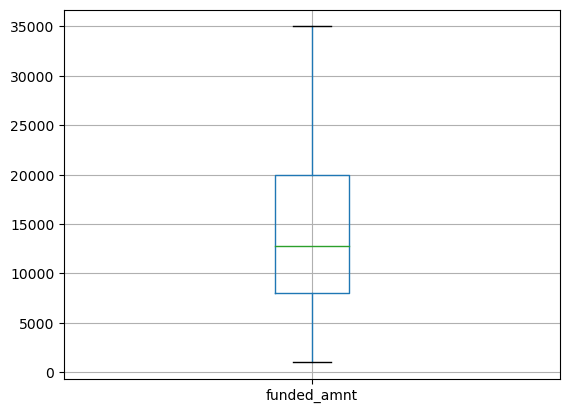

Top 3 Max:  [1409.99, 1409.99, 1408.13] 
Min:  21.62


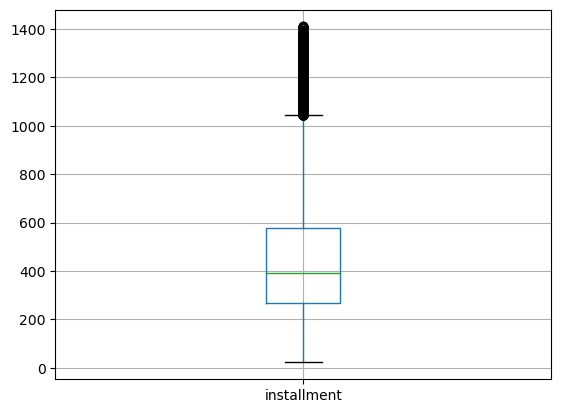

Top 3 Max:  [7500000.0, 7446395.0, 7141778.0] 
Min:  3000.0


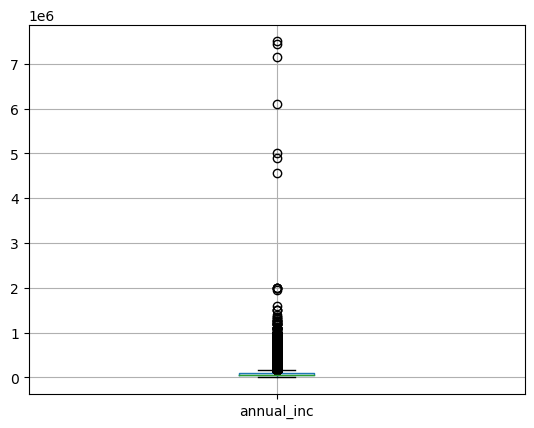

Top 3 Max:  [39.99, 39.99, 39.99] 
Min:  0.0


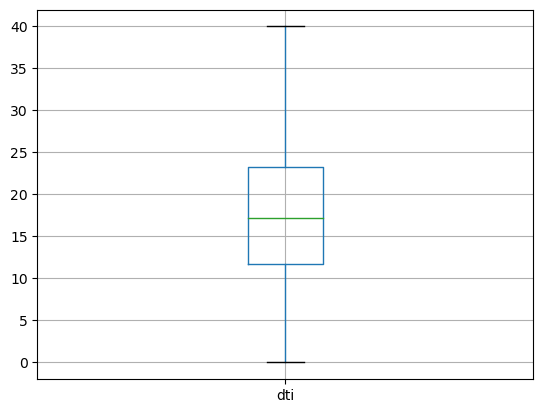

Top 3 Max:  [2568995.0, 2560703.0, 1746716.0] 
Min:  0.0


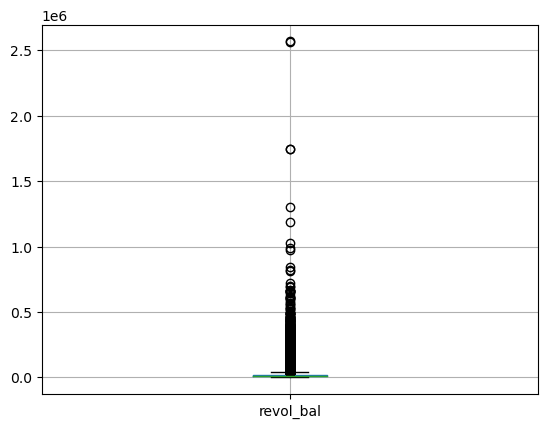

Top 3 Max:  [29.0, 24.0, 22.0] 
Min:  0.0


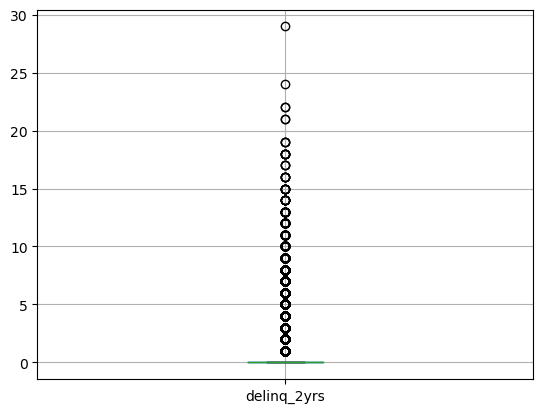

Top 3 Max:  [84.0, 76.0, 76.0] 
Min:  0.0


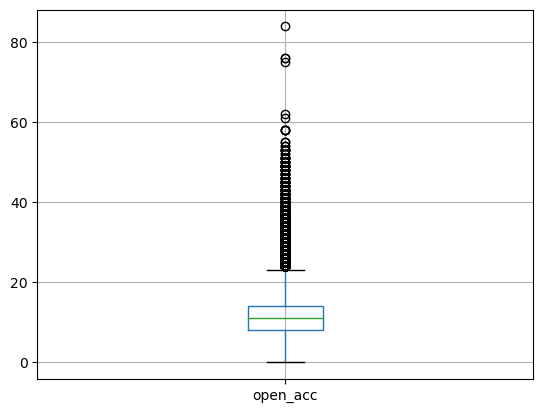

Top 3 Max:  [63.0, 54.0, 49.0] 
Min:  0.0


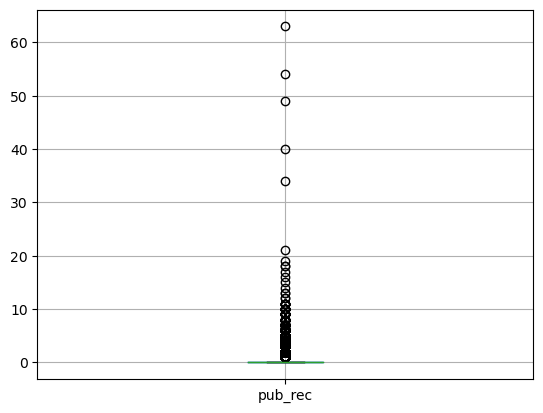

Top 3 Max:  [57898.1399038284, 57777.5798701654, 57716.2998455244] 
Min:  0.0


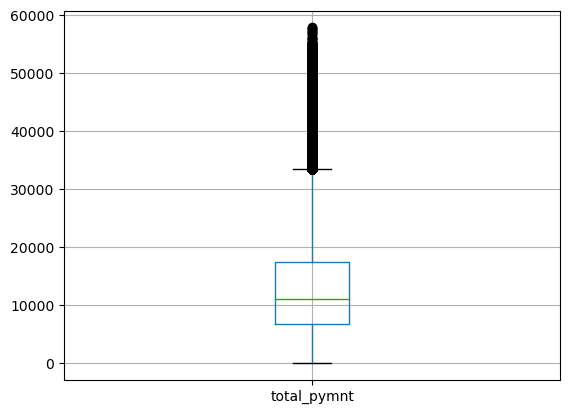

Top 3 Max:  [39443.64, 34294.1, 33520.27] 
Min:  0.0


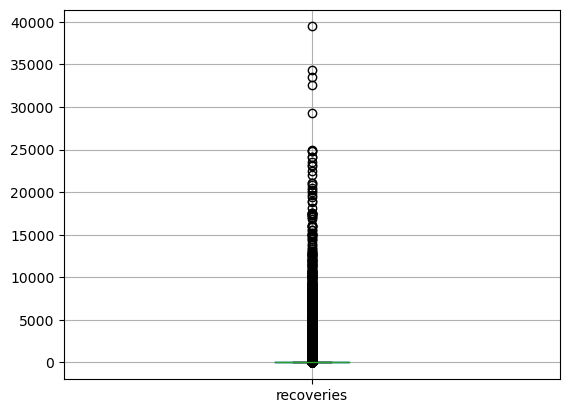

Top 3 Max:  [26.06, 26.06, 26.06] 
Min:  6.0


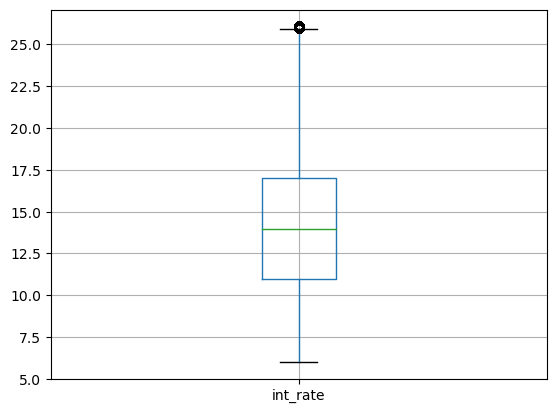

Top 3 Max:  [366.6, 153.0, 128.1] 
Min:  0.0


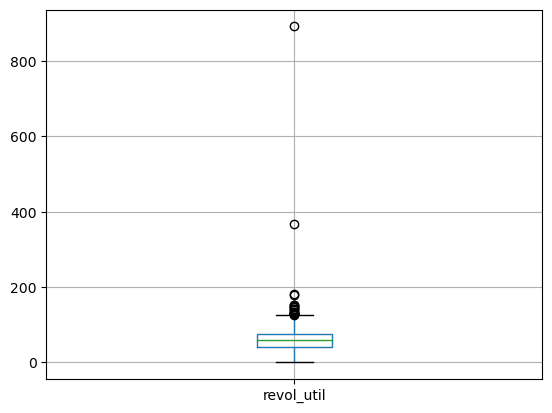

term
2 distinct values
 36 months    306420
 60 months    117332
Name: term, dtype: int64


grade
7 distinct values
B    124540
C    116553
D     70873
A     64684
E     32363
F     11929
G      2810
Name: grade, dtype: int64


emp_length
12 distinct values
10+ years    140680
2 years       36630
3 years       32232
< 1 year      31204
5 years       27316
1 year        26027
4 years       24374
7 years       24306
6 years       23737
8 years       20803
9 years       16547
Name: emp_length, dtype: int64


home_ownership
6 distinct values
MORTGAGE    216916
RENT        168293
OWN          38454
OTHER           46
NONE            42
ANY              1
Name: home_ownership, dtype: int64


verification_status
3 distinct values
Verified           154584
Source Verified    139688
Not Verified       129480
Name: verification_status, dtype: int64


loan_status
7 distinct values
Fully Paid            194025
Current               173065
Charged Off            46821
Late (31-120 days)      5117
I

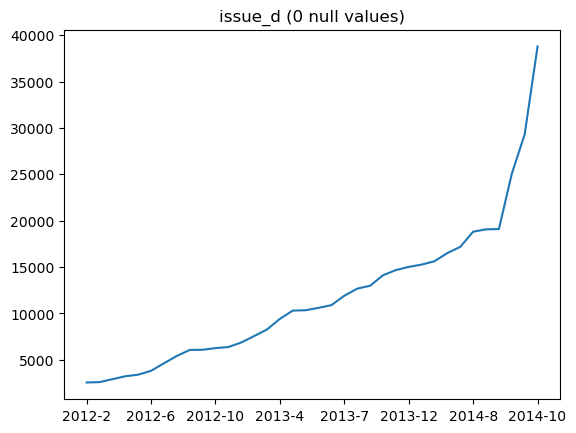

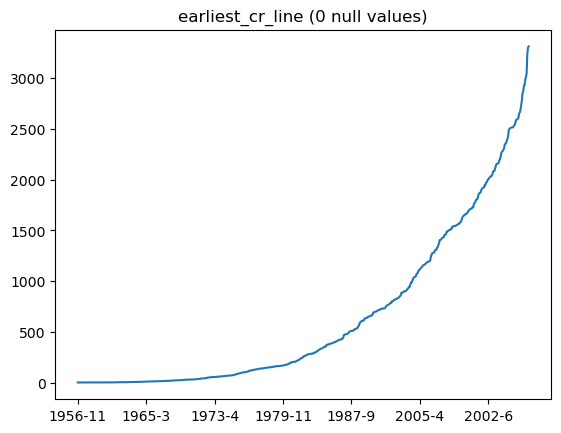

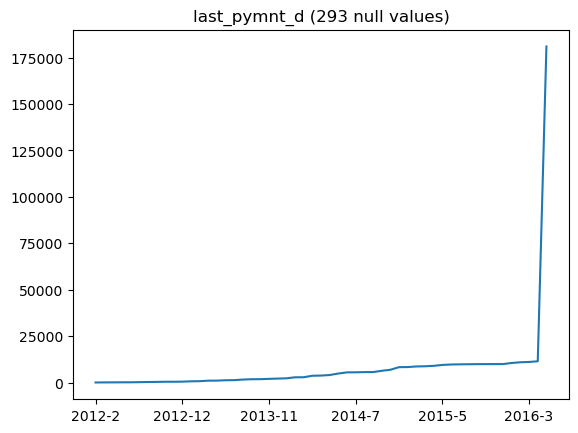

In [28]:
visualize_columns()


 # To do (B)

 Try visualizing the new variables and other pairs of variables


 ## Step 4 - Handle outliers

In [29]:
# There are quite a few outliers, but the two most obvious
# ones to remove are in annual_inc, revol_bal Remove these.
n_rows = len(final_data)
final_data = final_data[final_data.annual_inc < 1000000]
final_data = final_data[final_data.revol_bal < 400000]
final_data = final_data[final_data.dti < 200]
print("Removed " + str(n_rows - len(final_data)) + " rows")


Removed 120 rows


In [30]:
# Remove all loans that are too recent to have been paid off or
# defaulted
n_rows = len(final_data)
final_data = final_data[final_data.loan_status.isin(['Fully Paid','Charged Off','Default'])]
print("Removed " + str(n_rows - len(final_data)) + " rows")


Removed 182737 rows


In [31]:
# Only include loans issued since 2009
n_rows = len(final_data)
final_data = final_data[final_data.issue_d >= datetime.date(2009, 1, 1)]
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 0 rows


Top 3 Max:  [35000.0, 35000.0, 35000.0] 
Min:  1000.0


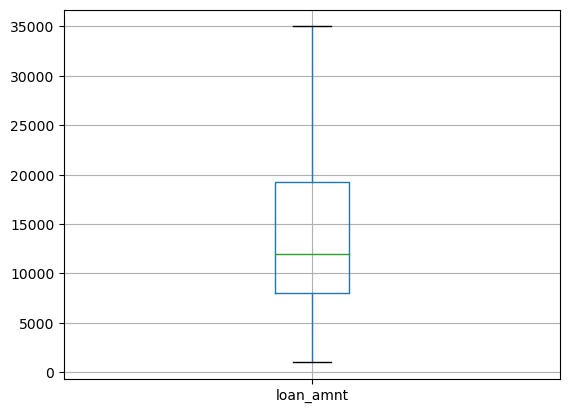

Top 3 Max:  [35000.0, 35000.0, 35000.0] 
Min:  1000.0


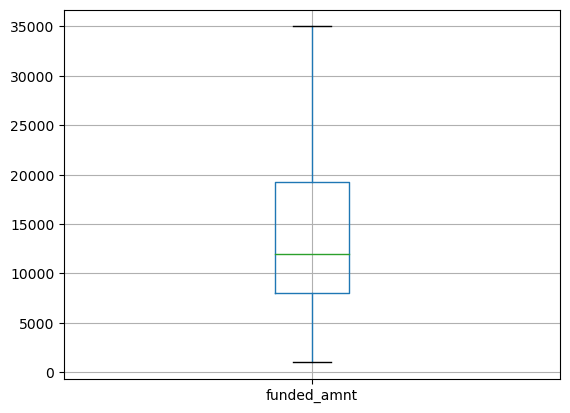

Top 3 Max:  [1408.13, 1408.13, 1408.13] 
Min:  21.62


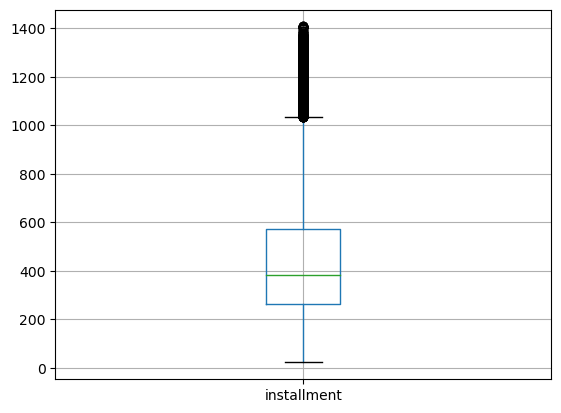

Top 3 Max:  [998000.0, 995000.0, 985000.0] 
Min:  3000.0


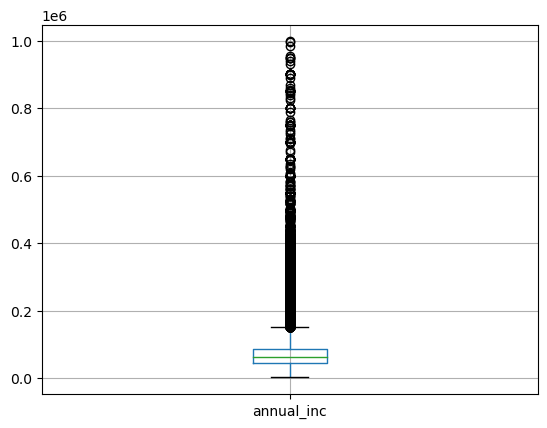

Top 3 Max:  [39.99, 39.99, 39.98] 
Min:  0.0


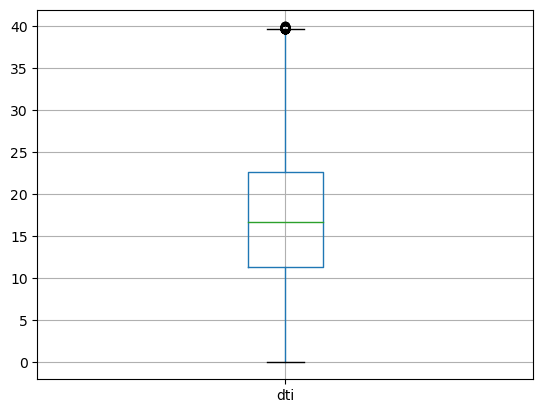

Top 3 Max:  [396587.0, 391404.0, 387060.0] 
Min:  0.0


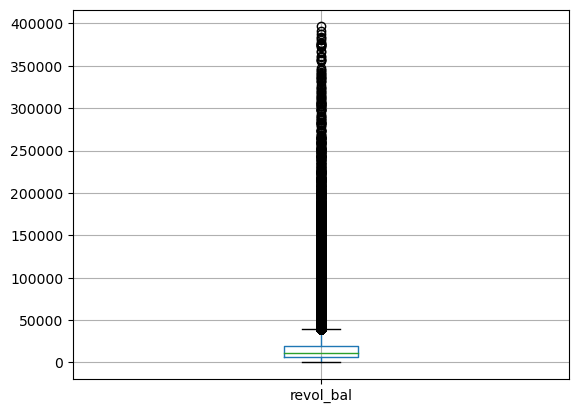

Top 3 Max:  [29.0, 24.0, 22.0] 
Min:  0.0


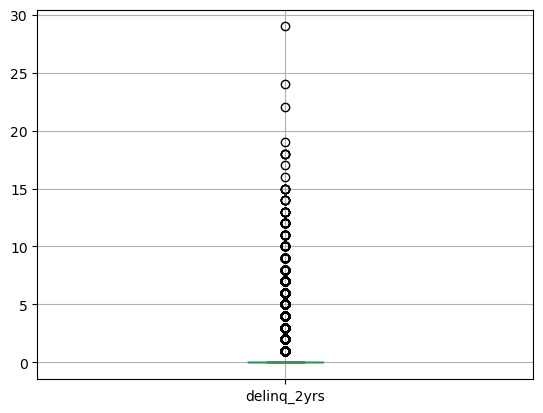

Top 3 Max:  [76.0, 76.0, 58.0] 
Min:  0.0


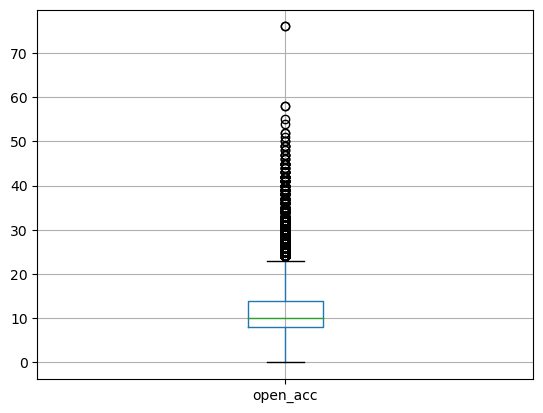

Top 3 Max:  [54.0, 13.0, 11.0] 
Min:  0.0


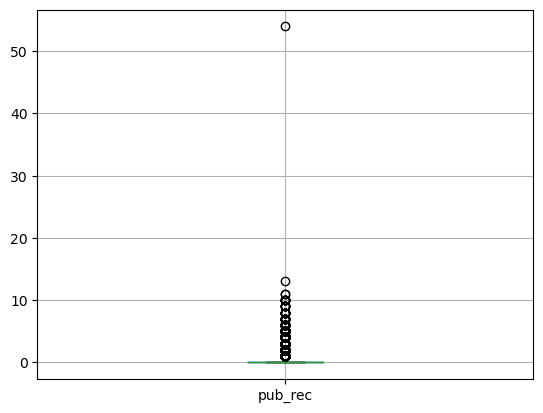

Top 3 Max:  [57898.1399038284, 57777.5798701654, 57716.2998455244] 
Min:  0.0


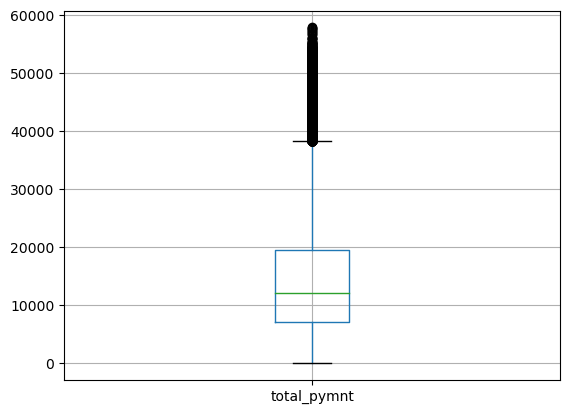

Top 3 Max:  [39443.64, 34294.1, 33520.27] 
Min:  0.0


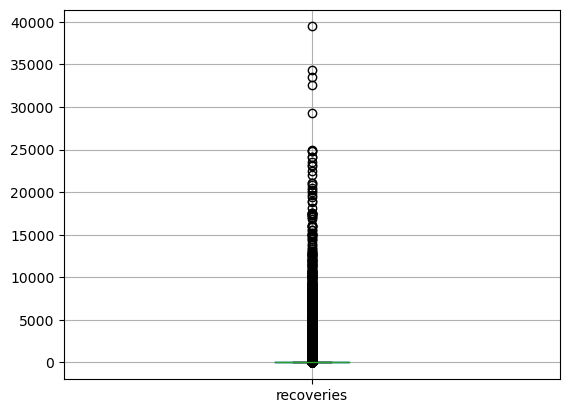

Top 3 Max:  [26.06, 26.06, 26.06] 
Min:  6.0


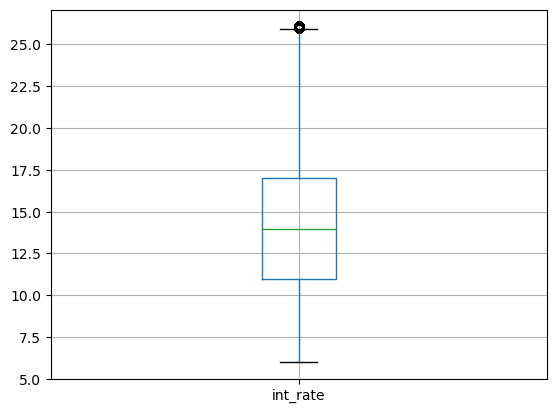

Top 3 Max:  [892.3, 150.7, 148.0] 
Min:  0.0


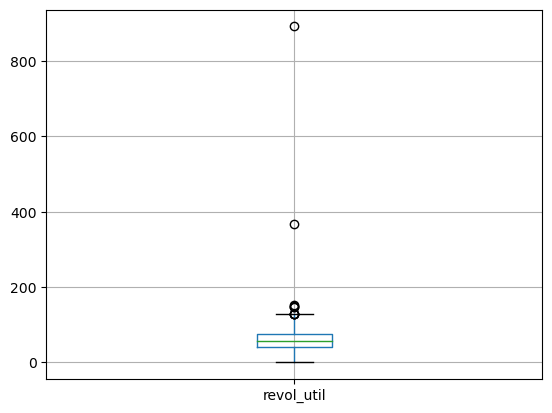

term
2 distinct values
 36 months    190573
 60 months     50322
Name: term, dtype: int64


grade
7 distinct values
B    74933
C    63785
D    39131
A    37230
E    17253
F     6913
G     1650
Name: grade, dtype: int64


emp_length
12 distinct values
10+ years    76574
2 years      21522
3 years      18690
< 1 year     18202
5 years      16759
1 year       15238
6 years      14475
4 years      14193
7 years      14123
8 years      11684
9 years       9310
Name: emp_length, dtype: int64


home_ownership
6 distinct values
MORTGAGE    121573
RENT         98546
OWN          20692
OTHER           43
NONE            40
ANY              1
Name: home_ownership, dtype: int64


verification_status
3 distinct values
Verified           92000
Not Verified       79409
Source Verified    69486
Name: verification_status, dtype: int64


loan_status
3 distinct values
Fully Paid     193970
Charged Off     46815
Default           110
Name: loan_status, dtype: int64


purpose
13 distinct values
debt_consol

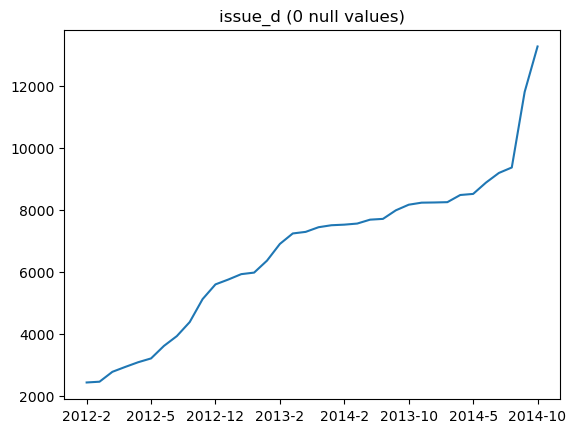

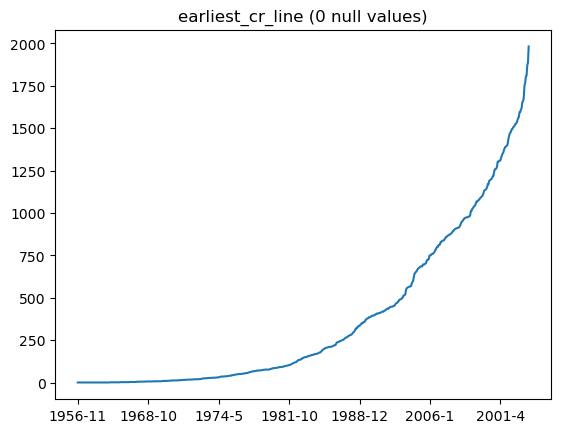

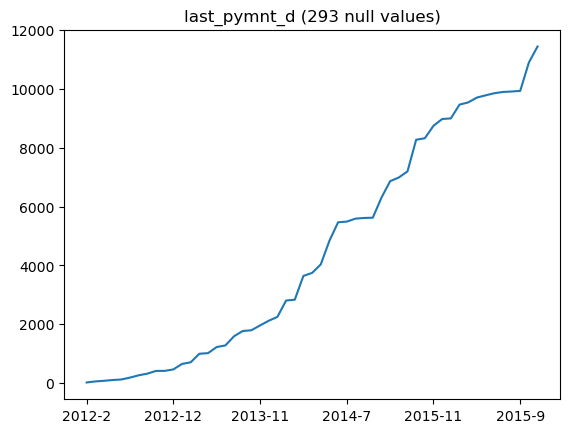

In [32]:
# Visualize the data again
visualize_columns()

 ### Drop null values

In [33]:
# Deal with null values. We allow categorical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement
required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)
final_data.dropna(subset = required_cols ,inplace=True)
print("Removed " + str(n_rows - len(final_data)) + " rows")


Removed 451 rows


In [34]:
# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.
#
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features
discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)


 ## Step 5 - Save a Pickle

In [35]:
# Remove the total_pymnt from the list of continuous features; this
# variable is highly predictive of the outcome but is not known at
# the time the loan is issued
continuous_features = [i for i in continuous_features if i not in ["total_pymnt", "recoveries"]]


In [36]:
# Define the output path for the pickle
pickle_file = "/".join(['.', "PickleData", "clean_data.pickle"])
os.makedirs(os.path.dirname(pickle_file), exist_ok=True)
pickle.dump( [final_data, discrete_features, continuous_features], open(pickle_file, "wb") )


In [37]:
final_data.head()


,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,dti,delinq_2yrs,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_pymnt,last_pymnt_d,recoveries
4,10129506,20800.0,20800.0,36 months,13.53,706.16,B,10+ years,RENT,81500.0,...,16.73,0.0,1998-06-01,29.0,0.0,23473.0,54.5,23926.640008,2015-05-01,0.0
6,10179520,3000.0,3000.0,36 months,12.85,100.87,B,10+ years,RENT,25000.0,...,24.68,0.0,1991-05-01,5.0,2.0,2875.0,54.2,3181.548905,2014-07-01,0.0
7,10139658,12000.0,12000.0,36 months,13.53,407.40,B,10+ years,RENT,40000.0,...,16.94,0.0,1998-10-01,7.0,2.0,5572.0,68.8,13359.776858,2015-09-01,0.0
10,10148122,12000.0,12000.0,36 months,7.62,373.94,A,3 years,MORTGAGE,96500.0,...,12.61,0.0,2003-09-01,17.0,0.0,13248.0,55.7,13397.539998,2016-06-01,0.0
12,10149577,28000.0,28000.0,36 months,7.62,872.52,A,5 years,MORTGAGE,325000.0,...,18.55,0.0,1994-11-01,15.0,0.0,29581.0,54.6,29150.980000,2014-08-01,0.0


 ## Read from Pickle if Saved
 Read data from saved pickle files

In [38]:
### Read the data and features from the pickle
final_data, discrete_features, continuous_features = pickle.load( open( "./PickleData/clean_data.pickle", "rb" ) )
#final_data, discrete_features, continuous_features = pickle.load( open( "./PickleData/201213clean_data.pickle", "rb" ) )


In [39]:
final_data.head()


,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,dti,delinq_2yrs,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_pymnt,last_pymnt_d,recoveries
4,10129506,20800.0,20800.0,36 months,13.53,706.16,B,10+ years,RENT,81500.0,...,16.73,0.0,1998-06-01,29.0,0.0,23473.0,54.5,23926.640008,2015-05-01,0.0
6,10179520,3000.0,3000.0,36 months,12.85,100.87,B,10+ years,RENT,25000.0,...,24.68,0.0,1991-05-01,5.0,2.0,2875.0,54.2,3181.548905,2014-07-01,0.0
7,10139658,12000.0,12000.0,36 months,13.53,407.40,B,10+ years,RENT,40000.0,...,16.94,0.0,1998-10-01,7.0,2.0,5572.0,68.8,13359.776858,2015-09-01,0.0
10,10148122,12000.0,12000.0,36 months,7.62,373.94,A,3 years,MORTGAGE,96500.0,...,12.61,0.0,2003-09-01,17.0,0.0,13248.0,55.7,13397.539998,2016-06-01,0.0
12,10149577,28000.0,28000.0,36 months,7.62,872.52,A,5 years,MORTGAGE,325000.0,...,18.55,0.0,1994-11-01,15.0,0.0,29581.0,54.6,29150.980000,2014-08-01,0.0


 ## Step 6 Prepare your presentation.

 Your presentation should contain at most 6 slides.

 1) Begin by giving an overview of the project. What is the problem you wish to solve, what are the objectives?

 How will you evaluate the performance of the portfolio you provide? How will you measure success?

 What are the business KPIs?

 2) What variables did you select for further inspection? Why do you think they will be useful?

 You may support any argument with a visualization.

 3) List any insight you gained by looking at the data visualization or any other data analysis that you perform.

 4) List 3-5 hypothesis about which variables will be important for analysis, and how they will affect the outcome.

 5) State your conclusions. What is the main idea you wish to convey with the presentation? Do you think the data available will be useful to solve the problem?
